In [2]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import keras
from keras import layers
from IPython.display import display
from PIL import ImageOps, Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

2024-02-29 21:29:48.018935: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-29 21:29:48.019112: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-29 21:29:48.193319: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# common 
parent_dir = "/kaggle/input/airbus-ship-detection"
# images directory
train_dir = os.path.join(parent_dir, "train_v2")
# target image segmentations file
target_train = os.path.join(parent_dir, "train_ship_segmentations_v2.csv")
# test images
test_dir = os.path.join(parent_dir, "test_v2/")

### Utility functions

In [4]:
def summary_counts(df):
    counts_df = df.groupby("counts")["ImageId"].size().reset_index()
    fig = plt.figure(figsize=(11, 4))
    fig.subplots_adjust(top=0.85)
    fig.suptitle(f"Total image count: {counts_df.loc[:, 'ImageId'].sum()}", fontweight='bold')
    gs = fig.add_gridspec(1, 2, width_ratios=[3, 1])
    ax1 = fig.add_subplot(gs[0])
    ax1.bar(counts_df.loc[:, "counts"], counts_df.loc[:, "ImageId"])
    ax1.set_xlabel('Number of Targets')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Targets Count per Image')
    ax1.grid(True)
    ax2 = fig.add_subplot(gs[1])
    percent = 100/len(df)
    values = [counts_df.loc[0, "ImageId"]*percent, counts_df.loc[1:, "ImageId"].sum()*percent]
    ax2.bar(["0", "1 or more"], values, width=0.1)
    ax2.set_xlabel('Number of Targets')
    ax2.set_ylabel('Percentage')
    ax2.set_title('No Target vs. Containing Target Images Counts')
    ax2.grid(True)
    plt.tight_layout()
    plt.show()
    

def plot_image_mask_pairs(image_list, rle_list, num_rows, num_cols, figsize=(12, 5)):
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    for i in range(num_rows):
        for j in range(num_cols):
            index = i * num_cols + j
            if index < len(image_list):
                image = plt.imread(image_list[index])
                axes[i, j].imshow(image, cmap='gray')
                mask = rle_to_mask(rle_list[index], image.shape)
                axes[i, j].imshow(mask, alpha=0.4, cmap='jet')
                axes[i, j].axis('off')
            else:
                axes[i, j].axis('off')
    plt.tight_layout()
    plt.show()
    
    
def get_single_img(path):
    return np.array(Image.open(path))


def count_values(df):
    return df.groupby("ImageId").count().value_counts().to_frame().reset_index()


def df_to_filepath(df, file_col="ImageId", parent_dir=train_dir):
    if parent_dir:
        return [os.path.join(parent_dir, image_id) for image_id in df[file_col]]
    else:
        return [row[file_col] for row in df.iterrows()]

    
def rle_to_mask(rle_list, img_shape):
    # Initialize a mask as an array full of zeros
    mask = np.zeros((img_shape[0] * img_shape[1]), dtype=np.uint8)
    if len(rle_list) > 0:
        # Iterate over each RLE string in the nested list
        for rle in rle_list:
            # Split the RLE string into individual elements
            rle_list = [int(x) for x in rle.split()]
            # Update mask values based on values extracted from the RLE string
            for i in range(0, len(rle_list), 2):
                # Extract start pixel and subtract 1 to ensure 0-indexing
                start_pixel = rle_list[i] - 1
                # Extract length value
                num_pixels = rle_list[i + 1]
                # Set the corresponding values of mask to 1s 
                mask[start_pixel:start_pixel + num_pixels] = 1
    # Reshape the mask according to the size of the original image
    return mask.reshape((img_shape[0], img_shape[1])).T


def agg_rles(rles):
    # Initialize an empty list to store grouped RLEs
    if rles.isna().any():
        return 0
    else:
        grouped_rles = []
        # Iterate over the rows of RLEs
        for rle in rles:
            # Append each RLE to the list of grouped RLEs
            grouped_rles.append(rle)
        return grouped_rles
    
    
def get_image_path_rle(df, target_dir=train_dir):
    """Extracts image paths and corresponding RLE-encoded masks from a DataFrame.

    Args:
        df (pd.DataFrame): DataFrame containing image filenames and RLE-encoded masks.
        target_dir (str): Directory containing the images. Defaults to train_dir.

    Returns:
        tuple: A tuple containing a list of image paths and a list of RLE-encoded masks.
    """
    paths = [os.path.join(target_dir, img_name) for img_name in df.iloc[:, 0]]
    rles = df.loc[:, "EncodedPixels"].tolist()
    filtered_rles = [rle if rle else [] for rle in rles]
    return paths, filtered_rles

### Data Exploration

In [5]:
# load target segmentations file
segmentations = pd.read_csv(target_train)
segmentations.head(10)

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
5,000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...
6,000194a2d.jpg,55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...
7,000194a2d.jpg,254389 9 255157 17 255925 17 256693 17 257461 ...
8,0001b1832.jpg,NaN
9,00021ddc3.jpg,108287 1 109054 3 109821 4 110588 5 111356 5 1...


In [6]:
# general data statistics
n_rows = len(segmentations)
n_images = segmentations.loc[:, "ImageId"].nunique()
no_target = segmentations[segmentations.iloc[:, 1].isna()]
target = segmentations[segmentations.iloc[:, 1].notna()]
n_unique_target = target.loc[:, "ImageId"].nunique()

print(f"Total number of data entries: {n_rows}, where:")
print(f"Total number of unique images: {n_images} (100%), where:")
print(f"\t-number of images with 1 and more targets to segment: {n_unique_target} ({round(n_unique_target/n_images, 2)*100}%)")
print(f"\t-number of images with no objects to segment: {len(no_target)} ({round(len(no_target)/n_images, 2)*100}%)")

Total number of data entries: 231723, where:
Total number of unique images: 192556 (100%), where:
	-number of images with 1 and more targets to segment: 42556 (22.0%)
	-number of images with no objects to segment: 150000 (78.0%)


In [7]:
# Group RLEs by 'ImageId' and aggregate them into lists
grouped = segmentations.groupby('ImageId')['EncodedPixels'].agg(agg_rles).to_frame().reset_index()
# cpunt the number of target objects for each image
grouped["counts"] = grouped["EncodedPixels"].apply(lambda x: x if x == 0 else len(x))
grouped

,ImageId,EncodedPixels,counts
0,00003e153.jpg,0,0
1,0001124c7.jpg,0,0
2,000155de5.jpg,[264661 17 265429 33 266197 33 266965 33 26773...,1
3,000194a2d.jpg,[360486 1 361252 4 362019 5 362785 8 363552 10...,5
4,0001b1832.jpg,0,0
...,...,...,...
192551,fffedbb6b.jpg,0,0
192552,ffff2aa57.jpg,0,0
192553,ffff6e525.jpg,0,0
192554,ffffc50b4.jpg,0,0


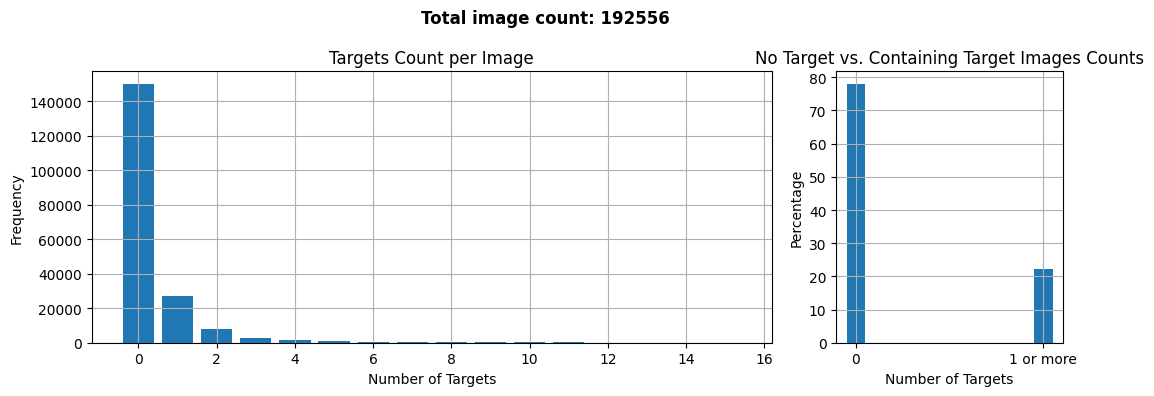

In [8]:
summary_counts(grouped)

### Image Visualizations

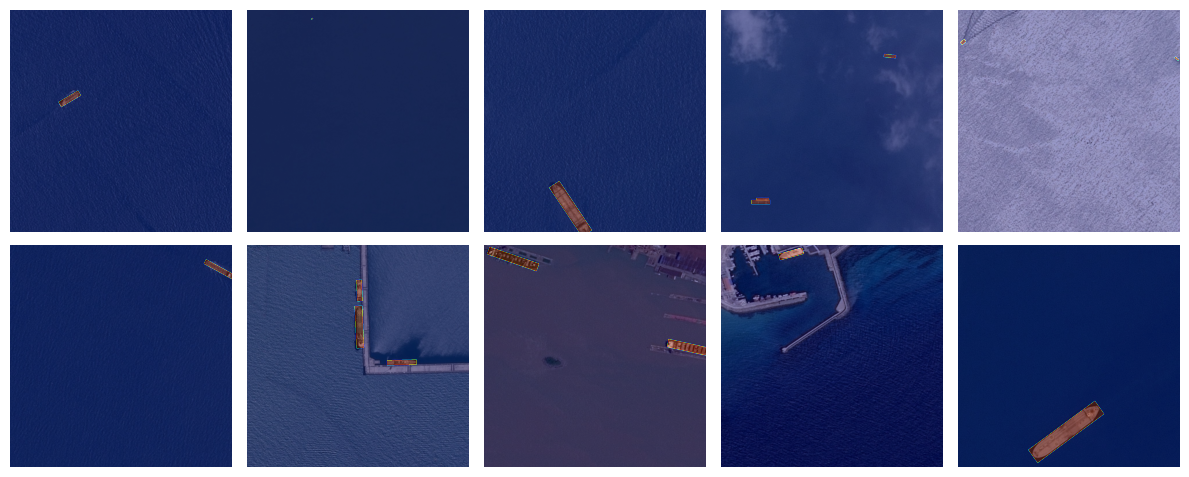

In [9]:
# load a sample of images with target and without
n_samples = 10
null_mask = grouped["EncodedPixels"] == 0
t_paths, t_rles = get_image_path_rle(grouped[~null_mask].sample(n=10))
no_t_paths, no_t_rles = get_image_path_rle(grouped[null_mask].sample(n=n_samples))

plot_image_mask_pairs(t_paths, t_rles, 2, 5)

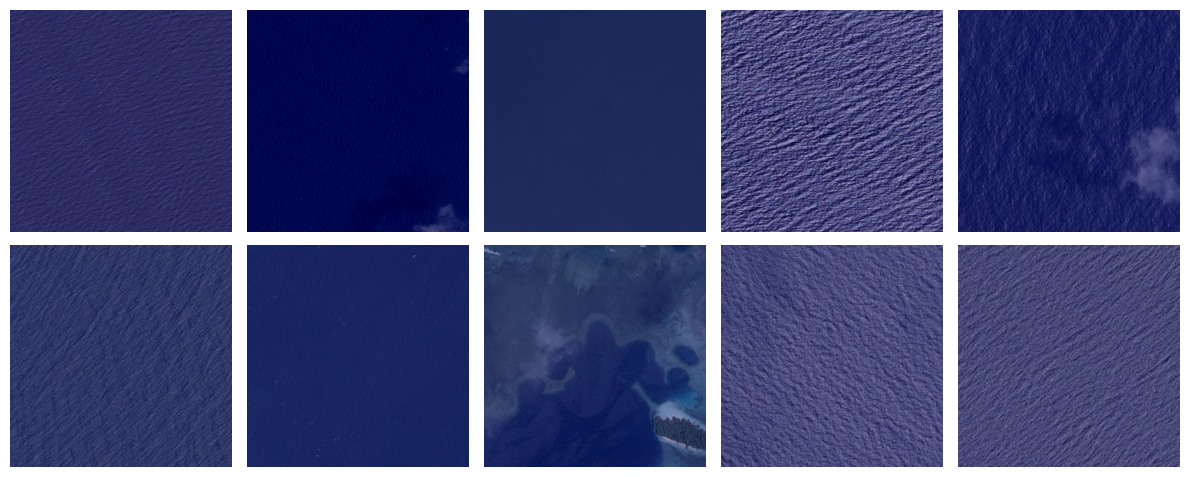

In [10]:
plot_image_mask_pairs(no_t_paths, no_t_rles, 2, 5)